In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

import tensorflow as tf
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
# set seed to reproduce similar results
np.random.seed(0)

In [ ]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data_path= "/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset"

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = os.path.join(prefix, group, 'Inertial Signals')
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['/total_acc_x_'+group+'.txt', '/total_acc_y_'+group+'.txt', '/total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['/body_acc_x_'+group+'.txt', '/body_acc_y_'+group+'.txt', '/body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['/body_gyro_x_'+group+'.txt', '/body_gyro_y_'+group+'.txt', '/body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(os.path.join(prefix, group,'y_'+group+'.txt'))
	return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset():
    # load all train
    trainX, trainy = load_dataset_group('train',  Data_path)
    # load all test
    testX, testy = load_dataset_group('test', Data_path)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy


In [ ]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [ ]:

# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()


(470528, 9)


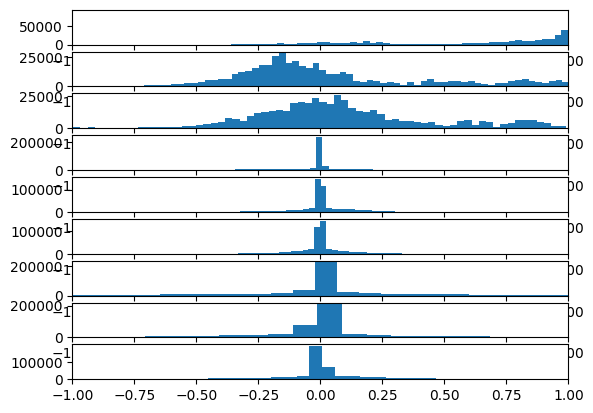

In [ ]:
# plot distributions
plot_distributions(trainX)

## 1. Based LSTM

In [ ]:

## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

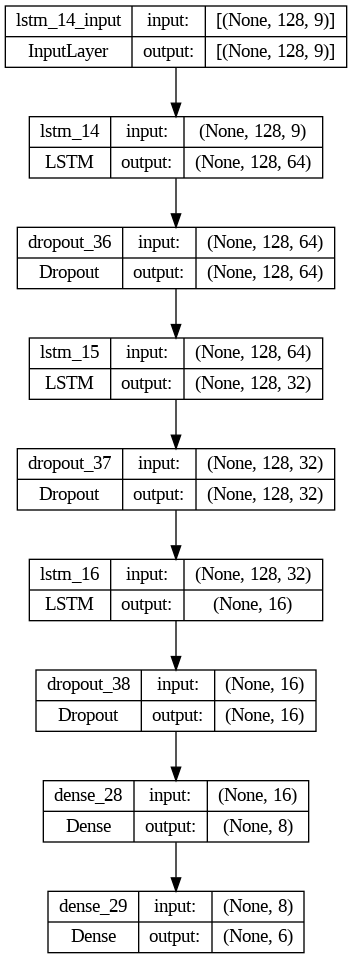

In [ ]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(16, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# fit network
train_epochs = 50
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/50
92/92 [==============================] - 8s 30ms/step - loss: 1.5125 - accuracy: 0.3411 - val_loss: 1.3531 - val_accuracy: 0.4222
Epoch 2/50
92/92 [==============================] - 2s 21ms/step - loss: 1.2395 - accuracy: 0.4924 - val_loss: 1.1442 - val_accuracy: 0.5942
Epoch 3/50
92/92 [==============================] - 2s 26ms/step - loss: 1.0443 - accuracy: 0.6115 - val_loss: 1.0301 - val_accuracy: 0.6193
Epoch 4/50
92/92 [==============================] - 2s 24ms/step - loss: 0.9358 - accuracy: 0.6632 - val_loss: 0.9642 - val_accuracy: 0.6818
Epoch 5/50
92/92 [==============================] - 3s 28ms/step - loss: 0.8442 - accuracy: 0.7320 - val_loss: 0.7670 - val_accuracy: 0.7464
Epoch 6/50
92/92 [==============================] - 2s 19ms/step - loss: 0.8082 - accuracy: 0.7329 - val_loss: 0.9268 - val_accuracy: 0.6390
Epoch 7/50
92/92 [==============================] - 2s 18ms/step - loss: 0.6183 - accuracy: 0.8131 - val_loss: 0.5960 - val_accuracy: 0.8287
Epoch 8/50
92

[]

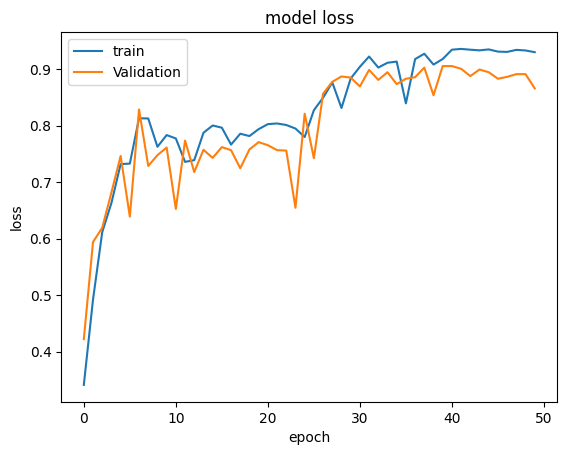

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.plot()

[]

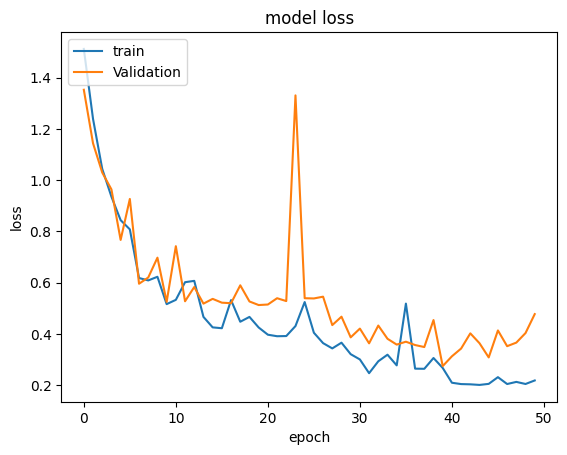

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.plot()


In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8998982310295105
93/93 [==============================] - 2s 7ms/step


In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[395  33  68   0   0   0]
 [  4 460   7   0   0   0]
 [  0   1 419   0   0   0]
 [  2   2   1 398  85   3]
 [ 10   0   1  78 443   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.80      0.87       496
           2       0.93      0.98      0.95       471
           3       0.84      1.00      0.91       420
           4       0.84      0.81      0.82       491
           5       0.84      0.83      0.84       532
           6       0.99      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



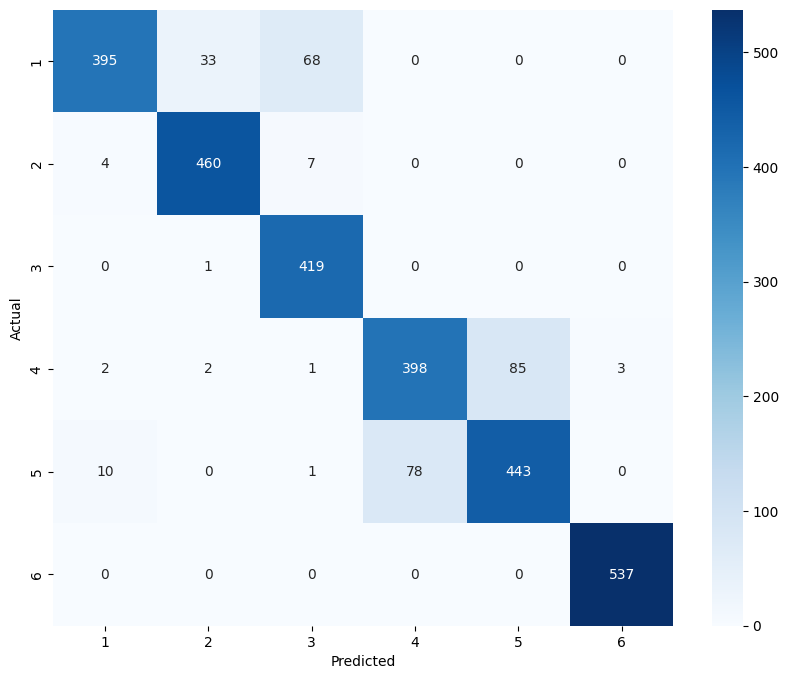

In [ ]:

classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

## 2.Based CNN

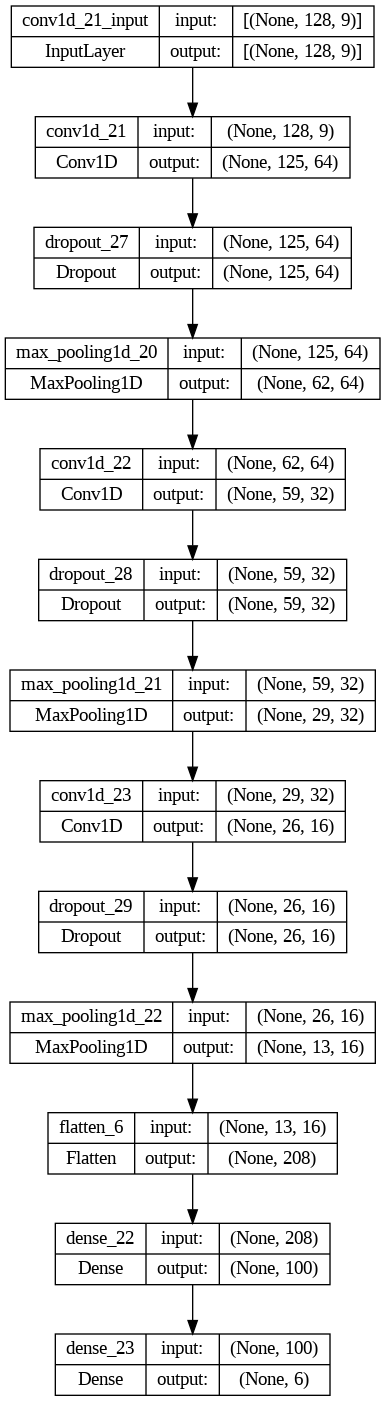

In [ ]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/20
92/92 [==============================] - 3s 10ms/step - loss: 0.8972 - accuracy: 0.6266 - val_loss: 0.7606 - val_accuracy: 0.7811
Epoch 2/20
92/92 [==============================] - 1s 6ms/step - loss: 0.3155 - accuracy: 0.8793 - val_loss: 0.5088 - val_accuracy: 0.9041
Epoch 3/20
92/92 [==============================] - 1s 6ms/step - loss: 0.2049 - accuracy: 0.9209 - val_loss: 0.4417 - val_accuracy: 0.9041
Epoch 4/20
92/92 [==============================] - 1s 7ms/step - loss: 0.1652 - accuracy: 0.9349 - val_loss: 0.3629 - val_accuracy: 0.9171
Epoch 5/20
92/92 [==============================] - 1s 7ms/step - loss: 0.1279 - accuracy: 0.9485 - val_loss: 0.3279 - val_accuracy: 0.8906
Epoch 6/20
92/92 [==============================] - 1s 8ms/step - loss: 0.1272 - accuracy: 0.9492 - val_loss: 0.3247 - val_accuracy: 0.9103
Epoch 7/20
92/92 [==============================] - 1s 9ms/step - loss: 0.1063 - accuracy: 0.9539 - val_loss: 0.3006 - val_accuracy: 0.9225
Epoch 8/20
92/92 [=

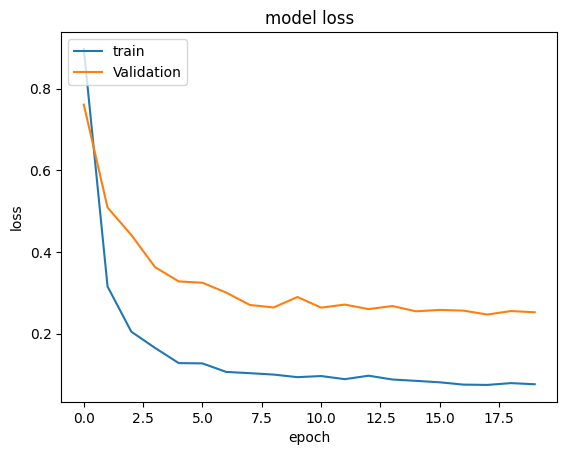

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)


Accuracy of the CNN model 0.9158466458320618
93/93 [==============================] - 0s 2ms/step


**** Confusion Matrix ****
[[496   0   0   0   0   0]
 [ 51 397  23   0   0   0]
 [  4   0 416   0   0   0]
 [  1   0   0 382 108   0]
 [  0   0   0  34 498   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.90      1.00      0.95       496
           2       0.94      0.84      0.89       471
           3       0.95      0.99      0.97       420
           4       0.92      0.78      0.84       491
           5       0.82      0.94      0.88       532
           6       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.91      2947



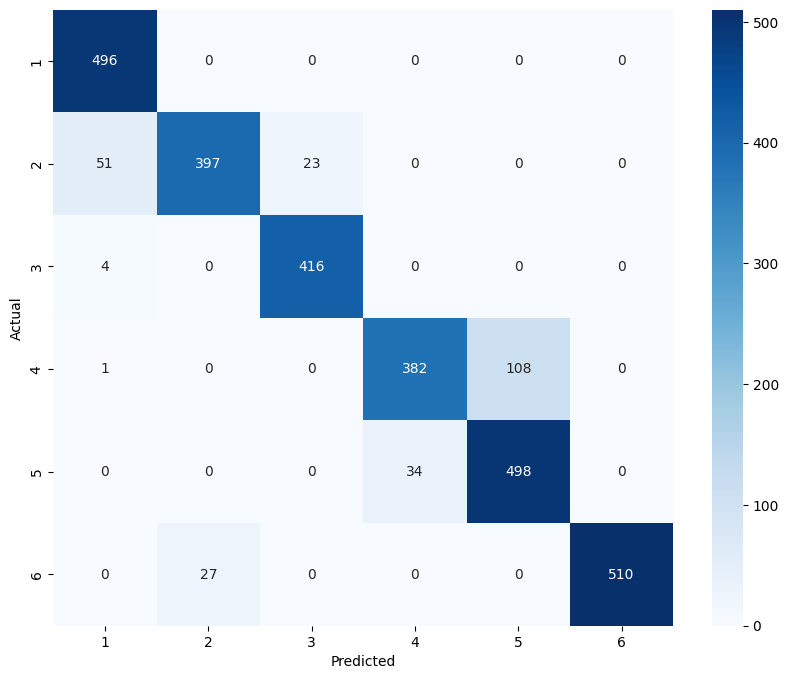

In [ ]:
display_results(testy,predictions,classNames)
